# Домашнее задание № 10. Машинный перевод

## Задание 1 (6 баллов + 2 доп балла).
Нужно обучить трансформер на том же корпусе но в другую сторону - с русского на английский.
Можно использовать как основу первый или второй способ реализации (с MultiheadAttention или с nn.Transformer). Подберите несколько тестовых примеров для проверки обучения на каждой эпохе. 

Параметры ниже точно работают в колабе и модель обучается достаточно быстро. Попробуйте их немного увеличить (batch size возможно придется наоборот уменьшить). Обучайте модель хотя бы 5 эпох, а желательно больше, чтобы тестовые примеры начали переводиться более менее адекватно. 

После обучения возьмите хотя бы 100 примером из тестовой части параллельного корпуса и переведите их. Оцените качество переводов с помощью метрики BLEU (пример использования ниже)
Найдите лучшие (как минимум 5) переводы согласно этой метрике и проверьте действительно ли они хорошие. Если все переводы нулевые, то пообучайте модель подольше.

Чтобы получить 2 доп балла вам нужно будет придумать как оптимизировать функцию translate. Сейчас она работает только с одним текстом - это не эффективно. Можно генерировать переводы сразу для нескольких текстов (батча). Главная сложность с таким подходом состоит в том, что генерируемые тексты будут заканчиваться в разное время и нужно сделать столько итераций, сколько нужно для завершения всех текстов (т.е. условие на то, что последний токен не равен [EOS] в текущем коде не сработает). 
ВАЖНО - недостаточно просто изменить входной аргумент с text на texts и добавить еще один цикл по texts! Сама модель должна вызываться на нескольких текстах! Функция с batch prediction должна работать быстрее, поэтому переведите всю тестовую выборку и оцените качество BLEU на всех данных.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from collections import Counter

from torchtune.modules import RotaryPositionalEmbeddings
from torch.nn import Transformer
%matplotlib inline

/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
text = open('./data/en-ru-train.ru').read().replace('\xa0', ' ')
f = open('./data/en-ru-train.ru', 'w')
f.write(text)
f.close()

<s>Я честно пытался сделать нормально, переписать где-то имена переменных и пр, но постоянно возникала ошибка с тем, что я получал вывод из translate на уровне
"Привет" > "G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G G"
поэтому</s> Теперь модель должна заработать, но я всё равно обучу пару ru-en взяв полностью код из семинара и применив небольшой трюк.
Он заключается в том, чтобы все имена переменных и весь код оставить в неизменном виде и поменять только именя файлов для тренировочных датасетов токенизаторов и модели. Таким образов в en-переменных окажутся токенизатор, сет, векторы, матрицы и пр, связанные с русским языком, а в ru-переменных -- с английским. Просто уже хочется перейти к интересной части домашки, а не заниматься переименовыванием переменных.

In [3]:
en_sents = open('./data/en-ru-train.ru').read().splitlines()  #  <-- Трюк
ru_sents = open('./data/en-ru-train.en').read().splitlines()  #  <-- Трюк

In [4]:
try:
    tokenizer_en = Tokenizer.from_file("./data/tokenizer_en")
    tokenizer_ru = Tokenizer.from_file("./data/tokenizer_ru")
    print("load existing")
except Exception:
    tokenizer_en = Tokenizer(BPE())
    tokenizer_en.pre_tokenizer = Whitespace()
    trainer_en = BpeTrainer(special_tokens=["[PAD]"], end_of_word_suffix='</w>')
    tokenizer_en.train(
        files=["./data/en-ru-train.ru"],  #  <-- Трюк
        trainer=trainer_en
    )

    tokenizer_ru = Tokenizer(BPE())
    tokenizer_ru.pre_tokenizer = Whitespace()
    trainer_ru = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')
    tokenizer_ru.train(
        files=["./data/en-ru-train.en"],  #  <-- Трюк
        trainer=trainer_ru
    )

    tokenizer_en.decoder = decoders.BPEDecoder()
    tokenizer_ru.decoder = decoders.BPEDecoder()

    tokenizer_en.save('./data/tokenizer_en')
    tokenizer_ru.save('./data/tokenizer_ru')
    print("create new")


load existing


In [5]:
def encode(text, tokenizer, max_len, encoder=False):
    if encoder:
        return tokenizer.encode(text).ids[:max_len]
    else:
        return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids[:max_len] + [tokenizer.token_to_id('[EOS]')]

In [6]:
# важно следить чтобы индекс паддинга совпадал в токенизаторе с value в pad_sequences
# у нас это в любом случае ноль но лучше safe than sorry
PAD_IDX = tokenizer_ru.token_to_id('[PAD]')
PAD_IDX

0

In [7]:
max_len_en, max_len_ru = 47, 48

In [17]:
X_en = [encode(t, tokenizer_en, max_len_en, encoder=True) for t in en_sents]
X_ru = [encode(t, tokenizer_ru, max_len_ru) for t in ru_sents]

In [18]:
len(X_en), len(X_ru)

(1000000, 1000000)

In [19]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, texts_en, texts_ru):
        self.texts_en = [torch.LongTensor(sent) for sent in texts_en]
        self.texts_en = torch.nn.utils.rnn.pad_sequence(self.texts_en, batch_first=True, padding_value=PAD_IDX)

        self.texts_ru = [torch.LongTensor(sent) for sent in texts_ru]
        self.texts_ru = torch.nn.utils.rnn.pad_sequence(self.texts_ru, batch_first=True, padding_value=PAD_IDX)

        self.length = len(texts_en)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        ids_en = self.texts_en[index]
        ids_ru = self.texts_ru[index]

        return ids_en, ids_ru

In [20]:
X_en_train, X_en_valid, X_ru_train, X_ru_valid = train_test_split(X_en, X_ru, test_size=0.05)

In [21]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self, vocab_size_enc, vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding_enc = nn.Embedding(vocab_size_enc, embed_dim)
        self.embedding_dec = nn.Embedding(vocab_size_dec, embed_dim)
        self.positional_encoding = RotaryPositionalEmbeddings(embed_dim // num_heads, max_seq_len=128)

        self.transformer = Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )

        self.output_layer = nn.Linear(embed_dim, vocab_size_dec)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):

        src_embedded = self.embedding_enc(src)
        B,S,E = src_embedded.shape
        src_embedded = self.positional_encoding(src_embedded.view(B,S,self.num_heads, E//self.num_heads)).view(B,S,E)

        tgt_embedded = self.embedding_dec(tgt)
        B,S,E = tgt_embedded.shape
        tgt_embedded = self.positional_encoding(tgt_embedded.view(B,S,self.num_heads, E//self.num_heads)).view(B,S,E)


        tgt_mask = (~torch.tril(torch.ones((S, S), dtype=torch.bool))).to(DEVICE)

        encoder_output = self.transformer.encoder(
            src_embedded,
            src_key_padding_mask=src_key_padding_mask
        )

        decoder_output = self.transformer.decoder(
            tgt_embedded,
            encoder_output,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )

        output = self.output_layer(decoder_output)
        return output

In [22]:
from time import time
def train(model, iterator, optimizer, criterion, scheduler, run=None, print_every=100):

    epoch_loss = []
    ac = []

    model.train()

    for i, (texts_en, texts_ru) in enumerate(iterator):
        texts_en = texts_en.to(DEVICE)
        texts_ru = texts_ru.to(DEVICE)
        texts_ru_input = texts_ru[:,:-1].to(DEVICE)
        texts_ru_out = texts_ru[:, 1:].to(DEVICE)
        src_padding_mask = (texts_en == PAD_IDX).to(DEVICE)
        tgt_padding_mask = (texts_ru_input == PAD_IDX).to(DEVICE)


        logits = model(texts_en, texts_ru_input, src_padding_mask, tgt_padding_mask)
        optimizer.zero_grad()
        B,S,C = logits.shape
        loss = loss_fn(logits.reshape(B*S, C), texts_ru_out.reshape(B*S))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)};')
        if run is not None:
            run.log({"loss": loss.item()})

    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion, run=None):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for i, (texts_en, texts_ru) in enumerate(iterator):
            texts_en = texts_en.to(DEVICE)
            texts_ru = texts_ru.to(DEVICE)
            texts_ru_input = texts_ru[:,:-1].to(DEVICE)
            texts_ru_out = texts_ru[:, 1:].to(DEVICE)
            src_padding_mask = (texts_en == PAD_IDX).to(DEVICE)
            tgt_padding_mask = (texts_ru_input == PAD_IDX).to(DEVICE)

            logits = model(texts_en, texts_ru_input, src_padding_mask, tgt_padding_mask)

            B,S,C = logits.shape
            loss = loss_fn(logits.reshape(B*S, C), texts_ru_out.reshape(B*S))
            epoch_loss.append(loss.item())
            if run is not None:
                run.log({"val_loss": loss.item()})

    return np.mean(epoch_loss)

In [23]:
@torch.no_grad
def translate(text):


    input_ids = tokenizer_en.encode(text).ids[:max_len_en]
    output_ids = [tokenizer_ru.token_to_id('[BOS]')]

    input_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(input_ids)], batch_first=True).to(DEVICE)
    output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)

    src_padding_mask = (input_ids_pad == PAD_IDX).to(DEVICE)
    tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

    logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)

    pred = logits.argmax(2).item()

    while pred not in [tokenizer_ru.token_to_id('[EOS]'), tokenizer_ru.token_to_id('[PAD]')] and len(output_ids) < 100:
        output_ids.append(pred)
        output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)
        tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

        logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)
        pred = logits.argmax(2).view(-1)[-1].item()

    return tokenizer_ru.decoder.decode([tokenizer_ru.id_to_token(i) for i in output_ids[1:]])

In [25]:
# попробуйте поставить параметры поменьше если в колабе обучается слишком долго!
vocab_size_enc = tokenizer_en.get_vocab_size()
vocab_size_dec = tokenizer_ru.get_vocab_size()
embed_dim = 256 # еще называется D_MODEL
num_heads = 8
ff_dim = embed_dim*4 # еще называется D_FF
num_layers = 4 # количество слоев

batch_size = 100


model = torch.load('model', weights_only=False)
model.eval()
# model = TransformerEncoderDecoder(vocab_size_enc,vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers)

TransformerEncoderDecoder(
  (embedding_enc): Embedding(30000, 256)
  (embedding_dec): Embedding(30000, 256)
  (positional_encoding): RotaryPositionalEmbeddings()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )


In [26]:
translate("Я люблю маму")

/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


'I love my mother .'

In [ ]:
training_set = Dataset(X_en_train, X_ru_train)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, )

valid_set = Dataset(X_en_valid, X_ru_valid)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [ ]:
from matplotlib import pyplot as plt

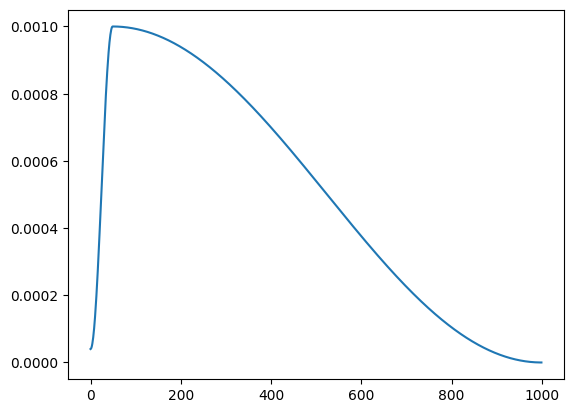

In [ ]:
fake_model = torch.nn.Linear(2, 1)
fake_optimizer = torch.optim.AdamW(fake_model.parameters(), lr=0.0001)
fake_scheduler = torch.optim.lr_scheduler.OneCycleLR(fake_optimizer, max_lr=0.001, pct_start=0.05,
                                                steps_per_epoch=50, epochs=20)
lrs = []

for i in range(1000):
    fake_optimizer.step()
    lrs.append(fake_optimizer.param_groups[0]["lr"])
    fake_scheduler.step()

plt.plot(lrs)

In [ ]:
model = model.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

NUM_EPOCHS = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, pct_start=0.05,
                                                steps_per_epoch=len(training_generator), epochs=NUM_EPOCHS)

In [ ]:
run = None

In [22]:
from timeit import default_timer as timer
NUM_EPOCHS = 20

losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train(model, training_generator, optimizer, loss_fn, scheduler, run)
    end_time = timer()
    val_loss = evaluate(model, valid_generator, loss_fn, run)

    if not losses:
        print(f'First epoch - {val_loss}, saving model..')
        torch.save(model, 'model')

    elif val_loss < min(losses):
        print(f'Improved from {min(losses)} to {val_loss}, saving model..')
        torch.save(model, 'model')

    losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, \
           "f"Epoch time={(end_time-start_time):.3f}s"))

    print(translate("Привет!"))
    print(translate('Как твои дела?'))
    print(translate('Как жена, как дети?'))
    print(translate('съешь же ещё этих мягких французских булок, да выпей чаю'))

Loss: 9.141746759414673;
Loss: 8.615472731590271;
Loss: 8.193301642735799;
Loss: 7.868091729879379;
Loss: 7.626520300865173;
Loss: 7.44104191382726;
Loss: 7.290940326281956;
Loss: 7.171681789159774;
Loss: 7.068861685329013;
Loss: 6.979812559127808;
Loss: 6.900501418980685;
Loss: 6.827723447879156;
Loss: 6.761177597779494;
Loss: 6.701167850153786;
Loss: 6.642160833358765;
Loss: 6.590262079238892;
Loss: 6.541541478213142;
Loss: 6.493674022886488;
Loss: 6.449504480361939;
Loss: 6.406869073867798;
Loss: 6.365596494901748;
Loss: 6.326820824796504;
Loss: 6.289682043946308;
Loss: 6.253461649815241;
Loss: 6.2178367319107055;
Loss: 6.1845130916742175;
Loss: 6.151026591548213;
Loss: 6.119829986095429;
Loss: 6.089503892701248;
Loss: 6.060107823053996;
Loss: 6.030702410667173;
Loss: 6.003473145514727;
Loss: 5.975772395856453;
Loss: 5.948673771128935;
Loss: 5.9233702989305765;
Loss: 5.897626327408685;
Loss: 5.872930125674686;
Loss: 5.849010893671136;
Loss: 5.8250460315362;
Loss: 5.802195795416832;


/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


First epoch - 3.9906687960624696, saving model..
Epoch: 1, Train loss: 5.004, Val loss: 3.991,            Epoch time=1535.213s
Hi !
How are you ?
How are you ?
And then you ' re gonna get the hell out of these ,
Loss: 4.0228636980056764;
Loss: 4.009443733692169;
Loss: 4.006328652699788;
Loss: 4.00545658826828;
Loss: 4.003859479427337;
Loss: 4.001544729073842;
Loss: 3.9987537830216544;
Loss: 3.9961545234918594;
Loss: 3.9939771585994297;
Loss: 3.9899342179298403;
Loss: 3.98518888798627;
Loss: 3.980758506457011;
Loss: 3.977944076061249;
Loss: 3.9748573306628634;
Loss: 3.9738698366483054;
Loss: 3.9711970692873;
Loss: 3.967009813364814;
Loss: 3.9630364553133646;
Loss: 3.959605048204723;
Loss: 3.9561953246593475;
Loss: 3.9524463454882306;
Loss: 3.949324184764515;
Loss: 3.945213615168696;
Loss: 3.9421158228317896;
Loss: 3.93793953666687;
Loss: 3.934808613061905;
Loss: 3.932689008977678;
Loss: 3.928394382596016;
Loss: 3.925597541085605;
Loss: 3.9222169999281564;
Loss: 3.919169738984877;
Loss: 

KeyboardInterrupt: 

### 8 эпох

In [28]:
print(translate('Меня всё время спрашивают: знаю ли я Тайлера Дёрдена?'))

I ' m gonna ask you all the time : do I know Tyler Drake ?


In [26]:
text = open('./data/en-ru-test.ru').read().replace('\xa0', ' ')
f = open('./data/en-ru-test.ru', 'w')
f.write(text)
f.close()

In [33]:
en_test_sents = open('./data/en-ru-test.en').read().splitlines()[666:777]  #  <-- Тут теперь настоящие английские предложения
ru_test_sents = open('./data/en-ru-test.ru').read().splitlines()[666:777]  #  <-- А тут русские

In [35]:
len(en_test_sents), len(ru_test_sents)

(111, 111)

In [36]:
en_test_sents[13], ru_test_sents[13]

("But we'll get through this, okay? I promise.",
 'Но мы как-нибудь выкрутимся.')

In [37]:
translations = []

for ru_, en_ in zip(ru_test_sents, en_test_sents):
    translations.append(
        {
            "inpt": ru_,
            "fact": translate(ru_),
            "expt": en_,
        }
    )

In [38]:
translations[0]

{'inpt': 'Одним из элементов является программа интеграции дополнительного устройства для автоматической подачи листовой обложки T.I.P. E 1530.',
 'fact': 'One element is the integration of additional device for automatic control of the T . I . P . 1530 .',
 'expt': 'The T.I.P. E 1530 additional infeeder is one element for this purpose.'}

#### Нужно очистить всё от пунктуации и оставить только слова.

In [39]:
from string import punctuation

In [40]:
def preproc(string):
    translator = string.maketrans("", "", punctuation)
    return string.translate(translator).strip()


In [41]:
for i in range(len(translations)):
    thriplet = translations[i]
    thriplet["fact"] = preproc(thriplet["fact"])
    thriplet["expt"] = preproc(thriplet["expt"])

In [42]:
translations[0]

{'inpt': 'Одним из элементов является программа интеграции дополнительного устройства для автоматической подачи листовой обложки T.I.P. E 1530.',
 'fact': 'One element is the integration of additional device for automatic control of the T  I  P  1530',
 'expt': 'The TIP E 1530 additional infeeder is one element for this purpose'}

In [43]:
translations[13]

{'inpt': 'Но мы как-нибудь выкрутимся.',
 'fact': 'But we  ll get some more',
 'expt': 'But well get through this okay I promise'}

In [44]:
import nltk

In [45]:
for i in range(len(translations)):
    thriplet = translations[i]
    fact = thriplet["fact"].lower().split()
    expt = thriplet["expt"].lower().split()
    thriplet["bleu"] = nltk.translate.bleu_score.sentence_bleu([fact], expt, auto_reweigh=True)

/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independen

In [48]:
translations[13]

{'inpt': 'Но мы как-нибудь выкрутимся.',
 'fact': 'But we  ll get some more',
 'expt': 'But well get through this okay I promise',
 'bleu': 1.2882297539194154e-231}

In [49]:
sorted(translations, key=lambda d: d["bleu"], reverse=True)[:10]

[{'inpt': 'Рабочая группа одобрила содержание проекта статьи 15 и передала его на рассмотрение редакционной группе.',
  'fact': 'The Working Group approved the substance of draft article 15 and referred it to the drafting group',
  'expt': 'The Working Group approved the substance of draft article 15 and referred it to the drafting group',
  'bleu': 1.0},
 {'inpt': '98799', 'fact': '98799', 'expt': '98799', 'bleu': 1.0},
 {'inpt': 'Опубликовано: 24 Октябрь 2014',
  'fact': 'Published  24 October 2014',
  'expt': 'Published 24 October 2014',
  'bleu': 1.0},
 {'inpt': 'Вы сказали - федеральные агенты?',
  'fact': 'Did you say federal agents',
  'expt': 'Did you say federal agents',
  'bleu': 1.0},
 {'inpt': 'Чтобы заставить Нейтона ревновать.',
  'fact': 'To make Nathan jealous',
  'expt': 'Just to make Nathan jealous',
  'bleu': 0.668740304976422},
 {'inpt': 'Click to see the amount of minerals in Fruits, vegetables, fats, cereals, spices and nuts rich in Phosphorus',
  'fact': 'Click t

### Получилось более-менее. Можно попробовать попереводить что-то длинное.

In [58]:
en_test_sents = open('./data/en-ru-test.en').read().splitlines()  #  <-- Тут теперь настоящие английские предложения
ru_test_sents = open('./data/en-ru-test.ru').read().splitlines()  #  <-- А тут русские

In [59]:
to_translate = []

for i, sent in enumerate(ru_test_sents):
    if len(sent) > 50:
        to_translate.append(i)
    if len(to_translate) == 100:
        break

In [60]:
len(to_translate)

100

In [61]:

translations = []

for i in to_translate:
    ru_ = ru_test_sents[i]
    en_ = en_test_sents[i]
    translations.append(
        {
            "inpt": ru_,
            "fact": preproc(translate(ru_)),
            "expt": preproc(en_),
        }
    )

In [62]:
translations[13]

{'inpt': 'В ОАО «ТГК-1» подведены итоги производственной и финансово-хозяйственной деятельности за 9 месяцев 2009 года.',
 'fact': 'The results of the production and financial sector in OJSC MMK amounted to the results of the year 2009',
 'expt': 'JSC TGC1 releases its 3rdQuarter and 9 months 2010 financial results according to Russian accounting standards'}

In [63]:
for i in range(len(translations)):
    thriplet = translations[i]
    fact = thriplet["fact"].lower().split()
    expt = thriplet["expt"].lower().split()
    thriplet["bleu"] = nltk.translate.bleu_score.sentence_bleu([fact], expt, auto_reweigh=True)

In [64]:
translations[13]

{'inpt': 'В ОАО «ТГК-1» подведены итоги производственной и финансово-хозяйственной деятельности за 9 месяцев 2009 года.',
 'fact': 'The results of the production and financial sector in OJSC MMK amounted to the results of the year 2009',
 'expt': 'JSC TGC1 releases its 3rdQuarter and 9 months 2010 financial results according to Russian accounting standards',
 'bleu': 1.0679799769055672e-231}

In [65]:
sorted(translations, key=lambda d: d["bleu"], reverse=True)[:10]

[{'inpt': 'Вьетнам озабочен фактом эскалации насилия в отношении невинных гражданских лиц.',
  'fact': 'Viet Nam is concerned about the fact that violence against innocent civilians',
  'expt': 'Viet Nam is concerned about the escalating violence against innocent civilians',
  'bleu': 0.6407117598241614},
 {'inpt': 'Слушай, когда твой отец предложил мне место для того, чтобы остаться',
  'fact': 'Listen  when your dad suggested me a place to stay',
  'expt': 'Look when your dad offered me a place to stay',
  'bleu': 0.5253819788848316},
 {'inpt': 'Мытищинский Район (Московская Область) 498684 **** Телефон',
  'fact': 'Moscow Region  Moscow Region  498684  Phone',
  'expt': 'Mytischinskiy District Moscow Region 498684  Phone',
  'bleu': 0.5081327481546147},
 {'inpt': 'Совещание Сигнатариев Протокола по проблемам воды и здоровья к Конвенции',
  'fact': 'Signatories to the Protocol on Water and Health Aspects of the Convention',
  'expt': 'Meeting of the Signatories to the Protocol on Wat

### Тут всё уже не так гладко.

In [66]:
translations[11]

{'inpt': 'Для детей с дефектами умственного и физического развития, лишенных родительской опеки, сирот и брошенных детей, действует 56 интернатов, 6 детских домов, 2 дома ребенка.',
 'fact': 'For children with defects and physical disabilities  deprived parental care  orphans and children  are employed by 56 schools  6 kindergartens  2 children',
 'expt': 'There are 56 boarding schools six homes for overfives and two for underfives for children with physical or mental disabilities children lacking parental protection and orphaned and abandoned children',
 'bleu': 2.266467503234495e-78}

### Теперь можно доработать translate
#### Для начала замерим старую

In [67]:
to_translate = ru_test_sents[:100]

In [68]:
min(to_translate)

'!две раздельные комнаты и кухня, кондиционер, бойлер, Wi-Fi! подробнее...'

In [69]:
max(to_translate, key=len)

'Несмотря на жесткую экономическую, торговую и финансовую блокаду, введенную в отношении Кубы правительством Соединенных Штатов более четырех десятилетий назад, Куба осуществляет и будет продолжать осуществлять программы сотрудничества со странами Африки, Карибского бассейна и другими братскими странами «третьего мира» в рамках совместных усилий, направленных на преодоление последствий работорговли и других печальных явлений колониализма и неоколониализма.'

In [70]:
%%time
for _ in range(10):
    for sent in to_translate:
        translate(sent)

CPU times: user 26min 58s, sys: 1.33 s, total: 26min 59s
Wall time: 1min 57s


#### Теперь можно попробовать пооптимизировать

In [71]:
@torch.no_grad
def batch_translate(texts):


    input_ids = [
        tokenizer_en.encode(text).ids[:max_len_en]
        for text in texts
    ]

    output_ids = [
        [tokenizer_ru.token_to_id('[BOS]')]
        for text
        in texts
    ]

    input_ids_pads = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(ids) for ids in input_ids],
        batch_first=True
    ).to(DEVICE)

    output_ids_pads = torch.nn.utils.rnn.pad_sequence(
        [torch.LongTensor(ids) for ids in output_ids],
        batch_first=True
    ).to(DEVICE)

    src_padding_mask = (input_ids_pads == PAD_IDX).to(DEVICE)
    tgt_padding_mask = (output_ids_pads == PAD_IDX).to(DEVICE)

    # Идея в том, чтобы на каждом витке вопхать в модель сразу весь многомерный тензор и потом посмотреть, какие предложения закончились
    finished = [False for _ in range(len(texts))]
    logits = model(input_ids_pads, output_ids_pads, src_padding_mask, tgt_padding_mask)
    preds = logits.argmax(2)

    while len(max(output_ids)) < 100 and not all(finished):
        for i in range(len(finished)):
            if not finished[i]:
                item = preds[i].item()
                if item in {tokenizer_ru.token_to_id('[EOS]'), tokenizer_ru.token_to_id('[PAD]')}:
                    finished[i] = True
                else:
                    output_ids[i].append(item)

        output_ids_pads = torch.nn.utils.rnn.pad_sequence(
            [torch.LongTensor(ids) for ids in output_ids],
            batch_first=True
        ).to(DEVICE)
        tgt_padding_mask = (output_ids_pads == PAD_IDX).to(DEVICE)

        logits = model(input_ids_pads, output_ids_pads, src_padding_mask, tgt_padding_mask)
        preds = logits[:, -1, :].argmax(1)  # <-- я не понимаю почему это работает

    return [
        tokenizer_ru.decoder.decode(
            [
                tokenizer_ru.id_to_token(i)
                for i
                in ids[1:]
            ]
        )
        for ids
        in output_ids
    ]

In [72]:
for ru_, en_ in zip(to_translate[10:20], batch_translate(to_translate[10:20])):
    print(ru_, en_, sep="\t")

Закон об объединениях, глава 66, (1972 год) требует, чтобы любой клуб, компания, товарищество или ассоциация, насчитывающие 10 или более человек, за исключением тех случаев, которые предусмотрены в разделе 2 этого закона, были внесены в регистр объединений.	The Associations Act , chapter 66 ( 1972 ) requires that any club , comrades or Associations , association or association , 10 or more than those in section 2 of the law , which are provided for in section 2 of the law , which are not
По мнению половины опрошенных казахстанских руководителей высшего звена, состояние мировой экономики в течение ближайших 12 месяцев не изменится.	According to the last half of the past year , the highest ranking of the world economy in the next 12 months will not change .
Коллекция администрации Адамса.	The Paris administration of the Adam administration .
Экономичное средство измерения расхода	Capacity - building
Tuyo Movil 571 *****	Tuo Mol 571 *****
Если вы точно уверены, что не продвинетесь выше в 

In [73]:
%%time
for _ in range(10):
    batch_translate(to_translate)

CPU times: user 1min 34s, sys: 223 ms, total: 1min 34s
Wall time: 9.69 s


In [75]:
en_test_sents = open('./data/en-ru-test.en').read().splitlines()
ru_test_sents = open('./data/en-ru-test.ru').read().splitlines()

In [76]:
len(ru_test_sents), len(en_test_sents)

(2000, 2000)

In [77]:
%%time
translations = []
batchsize = 100

for i in range(0, len(ru_test_sents), batchsize):
    j = i + batchsize

    translations.extend(
        batch_translate(ru_test_sents[i:j])
    )
    torch.cuda.empty_cache()

CPU times: user 3min 54s, sys: 2.56 s, total: 3min 56s
Wall time: 23.8 s


In [78]:
len(ru_test_sents), len(translations)

(2000, 2000)

In [80]:
ru_test_sents[1]

'И как ты только справляешься, папа, таская эти коробки взад-вперед целый день.'

In [81]:
metrics = []

for i in range(len(to_translate)):
    ru_ = ru_test_sents[i]
    en_ = en_test_sents[i]
    metrics.append(
        {
            "inpt": ru_,
            "fact": preproc(translations[i]),
            "expt": preproc(en_),
        }
    )

In [82]:
metrics[1]

{'inpt': 'И как ты только справляешься, папа, таская эти коробки взад-вперед целый день.',
 'fact': 'And as soon as you  re doing  Dad  these boxes are gonna go ahead',
 'expt': 'I dont know how you do it Pop carrying these boxes around every day'}

In [83]:
for i in range(len(metrics)):
    thriplet = metrics[i]
    fact = thriplet["fact"].lower().split()
    expt = thriplet["expt"].lower().split()
    thriplet["bleu"] = nltk.translate.bleu_score.sentence_bleu([fact], expt, auto_reweigh=True)

/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/smertlove/sandbox/hse/nlp_hw/compling_nlp_hw/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independen

In [84]:
metrics[1]

{'inpt': 'И как ты только справляешься, папа, таская эти коробки взад-вперед целый день.',
 'fact': 'And as soon as you  re doing  Dad  these boxes are gonna go ahead',
 'expt': 'I dont know how you do it Pop carrying these boxes around every day',
 'bleu': 5.3448396730677054e-155}

In [85]:
sorted(metrics, key=lambda d: d["bleu"], reverse=True)[:10]

[{'inpt': '- Боже, только послушайте себя.',
  'fact': 'Oh  God  listen to yourself',
  'expt': 'Oh God listen to yourself',
  'bleu': 1.0},
 {'inpt': '12844', 'fact': '12844', 'expt': '12844', 'bleu': 1.0},
 {'inpt': 'Дракон 5 out of 5 based on 1479 ratings.',
  'fact': 'Dragons 5 out of 5 based on 1479 ratings',
  'expt': 'Dragon 5 out of 5 based on 1464 ratings',
  'bleu': 0.6104735835807844},
 {'inpt': 'Я тебя люблю, папа.',
  'fact': 'I love you  Dad',
  'expt': 'I love you Dad How great',
  'bleu': 0.5081327481546147},
 {'inpt': 'Now, if you have kids yourself, you know what--',
  'fact': 'Now  if you have a decent  you know what',
  'expt': 'Now if you have kids yourself you know what',
  'bleu': 0.43167001068522526},
 {'inpt': 'Рассмотрение предложенных изменений и поправок к проекту текста Рабочей группы, содержащихся в докладах Специального комитета о работе его третьей сессии (A/AC.265/2004/5, приложение II) и четвертой сессии (A/59/360, приложение IV) и в предложениях, полу


## Задание 2 (2 балла).
Прочитайте главу про машинный перевод у Журафски и Маннига - https://web.stanford.edu/~jurafsky/slp3/13.pdf
Ответьте своими словами в чем заключается техника back translation? Для чего она применяется и что позволяет получить? Опишите по шагам как ее применить к паре en->ru на данных из семинара. Сколько моделей понадобится? Сколько запусков обучения нужно будет сделать?

Ответ должен содержать как минимум 10 предложений.